<a href="https://colab.research.google.com/github/thissop/MAXI-J1535/blob/main/code/machine-learning/December-%202021-2022/multicolinearity_corrected_(after_kfold_cv)_short.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# multicolinearity corrected (after kfold cv)

## Notes

* very good article for shap: [datatrigger blog](https://www.datatrigger.org/post/interpretable_machine_learning_shap/)

* I think I am not going to drop independent variables. Here's a rough blurb on what I'll say: 

    * In many cases, when assessing the individual predictive contributions of various indepedent variables, it is reccomended to deal with potential multicolinearity by calculating the Variance Inflation Factor (VIF) and removing features with VIF values ≳5 (\cite{kline1998principles}, \cite{Sheather2008-mc}). However, we have chosen not to remove potentially multicolinear features prior to regression for the following reasons. First, a tree based model like Random Forest (which is the focus of this work) is by design robust from the effects of multicolinearity (\cite{Strobl2008}, \cite{2021arXiv211102513C}). Second, since multicolinearity only affects the estimated coefficients of linear models, but not their predictive ability, applying a linear model to potentially multicolinear data is perfectly reasonable in our case, as we are using the linear model solely as a baseline against which we will compare the predictive capabilities of the more complicated Random Forest model, i.e. as we are applying the linear model we are not interested in its components (\cite{multicollinearity_class}, \cite{multicollinearity_regression}). We will, however, revist multicolinearity when we interpret feature importances in section \textbf{discussion}. 

* **IMPORTANT:** also saw something about the 

* we strive to emphasive interpretability and justification of our models and methods. 

* min max frequency range for normalization can be drawn from data processing procedure for nicer so that we can apply normalization to both train/test without having to worry about 

-----------------

* probably not going to use this article, but here it is: [Multicollinearity Correction and Combined Feature Effect in Shapley Values](https://arxiv.org/pdf/2011.01661.pdf)

* "All Models are wrong, but some are useful." - George Box, famous Bayesian statistician 

--------

Cool way to make rf graphs quickly: 

```python
regr = sklearn.tree.DecisionTreeRegressor()

dot_data = sklearn.tree.export_graphviz(regr, out_file=None, filled=True, rounded=True, special_characters=True)
graph = graphviz.Source(dot_data)
```

In [19]:
!pip install rebin
!pip install shap
import shap
import graphviz
from rebin import rebin 
import pandas as pd
import sklearn
import numpy as np 
import matplotlib.pyplot as plt
from sklearn.preprocessing import minmax_scale as normalize
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import mean_squared_error as mse_score
from sklearn.metrics import median_absolute_error as mae_score
from sklearn.metrics import accuracy_score as acc_score
from sklearn.metrics import r2_score 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge, LinearRegression
from sklearn.multioutput import RegressorChain
from sklearn import utils 
from sklearn.model_selection import KFold, StratifiedKFold

plt.style.use('https://raw.githubusercontent.com/thissop/MAXI-J1535/main/code/misc/stolen_science.mplstyle?token=GHSAT0AAAAAABP54PQO2X2VXMNS256IWOBOYRNCFBA')

rs = 4

In [14]:
# methods

def norm(x, min, max): 
    return (x - min) / (max - min)

def unnorm(x_, min, max):
    return x_*(max-min)+min

In [16]:
### FOR SPECTRAL INFORMATION!!

spectral_df = pd.read_csv('https://raw.githubusercontent.com/thissop/MAXI-J1535/main/code/misc/count_rates_initial_exploration/count_rates_transposed.csv')
qpo_df = pd.read_csv('https://raw.githubusercontent.com/thissop/MAXI-J1535/main/data/processed/2022/current_qpos.csv').fillna(0)


spectral_df.sort_values(by='full_id')
qpo_df.sort_values(by='full_id')

mask = np.where(np.isfinite(qpo_df['num_qpos']))

qpo_df = qpo_df.iloc[mask]

spectral_indices = []
for i in qpo_df['full_id']: 
    spectral_indices.append(np.where(spectral_df['full_id']==i)[0][0])

spectral_df = spectral_df.iloc[spectral_indices]

for i in ['first_freq', 'second_freq', 'first_width', 'second_width', 'first_norm', 'second_norm']: 
    qpo_df = qpo_df.astype({i:float})

for i, j in zip(qpo_df['full_id'], spectral_df['full_id']): 
    if i!=j: 
        print('mis-match')
        print(i,j)
# package x values

bins = 25

x = []

for i in range(len(spectral_df.index)): 
    counts_row = np.array(spectral_df.iloc[[i]])[0][1:].astype(float) 
    
    rebin_factor = int(np.floor(len(counts_row)/bins))
    
    rebined = rebin(counts_row, rebin_factor)
    x.append(rebined)

x = np.array(x)

# package y values

combined_freqs = np.concatenate((qpo_df['first_freq'], qpo_df['second_freq']))
min_freq, max_freq = (np.min(combined_freqs), np.max(combined_freqs))
combined_widths = np.concatenate((qpo_df['first_width'], qpo_df['second_width']))
min_width, max_width = (np.min(combined_widths), np.max(combined_widths))
combined_norms = np.concatenate((qpo_df['first_norm'], qpo_df['second_norm']))
min_norm, max_norm = (np.min(combined_norms), np.max(combined_norms))

y_col_names = ['first_freq', 'second_freq', 'first_width', 'second_width', 'first_norm', 'second_norm']
freq1s, freq2s = (norm(np.array(qpo_df[arr_name]), min_freq, max_freq) for arr_name in y_col_names[0:2])
width1s, width2s = (norm(np.array(qpo_df[arr_name]), min_width, max_width) for arr_name in y_col_names[2:4])
norm1s, norm2s = (norm(np.array(qpo_df[arr_name]), min_norm, max_norm) for arr_name in y_col_names[4:])

freqs = np.array([], dtype=float).reshape(0,2)
widths = np.array([], dtype=float).reshape(0,2)
norms = np.array([], dtype=float).reshape(0,2)

y_vals = []

for i in range(len(freq1s)): 
    row_matrix = np.array([freq1s[i], freq2s[i], width1s[i], width2s[i], norm1s[i], norm2s[i]])
    y_vals.append(row_matrix)

y_vals = np.array(y_vals)

x_vals = x
x_vals, y_vals, num_qpos = utils.shuffle(x_vals, y_vals, np.array(qpo_df['num_qpos']), random_state=rs)

(6, 29, 25)
(29, 25)


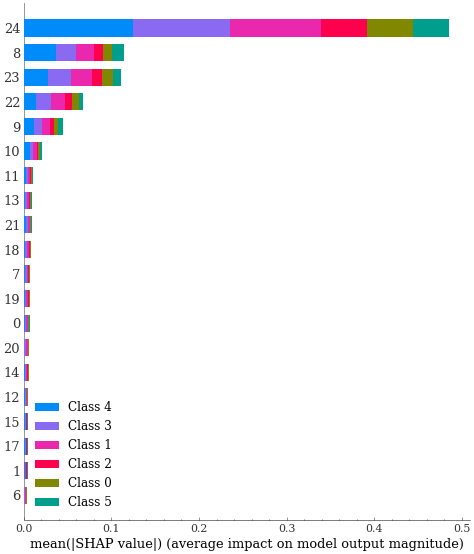

In [39]:
X_train, X_test, y_train, y_test = train_test_split(x_vals, y_vals, test_size=0.1, shuffle=True, random_state=rs)
regr = RandomForestRegressor()
regr.fit(X_train,y_train)

shap_values = shap.TreeExplainer(regr).shap_values(X_test)

# feature_perturbation: set to ‘interventional’ by default; "uses the shared dataset to compute conditional expectations in the presence of correlated input features."

# np.shape(shap_values) --> (a,b,c) 
#--> a: number of classes; b: number of datapoints; c: number of features

print(np.shape(shap_values))
print(X_test.shape)

labs = [str(i) for i in range(25)]

shap.summary_plot(shap_values, X_test, plot_type='bar', feature_names=labs)